In [1]:
# standard library imports
import pathlib
import warnings

warnings.simplefilter('ignore', category=FutureWarning)

# 3rd party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
from scipy.stats import f
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set()
pd.options.display.float_format = "{:.1f}".format

We begin by reading the data and summarizing the variables.

In [2]:
df = pd.read_csv('case0502.csv')
print(df.head())
df.groupby('Judge').describe()

   Percent    Judge
0      6.4  Spock's
1      8.7  Spock's
2     13.3  Spock's
3     13.6  Spock's
4     15.0  Spock's


Percent                                   
          count mean  std  min  25%  50%  75%  max
Judge                                             
A           5.0 34.1 11.9 16.8 30.8 33.6 40.5 48.9
B           6.0 33.6  6.6 27.0 29.7 32.4 34.8 45.6
C           9.0 29.1  4.6 21.0 27.5 30.5 32.5 33.8
D           2.0 27.0  3.8 24.3 25.6 27.0 28.4 29.7
E           6.0 27.0  9.0 17.7 20.1 24.7 33.1 40.2
F           9.0 26.8  6.0 16.5 23.5 26.7 29.8 36.2
Spock's     9.0 14.6  5.0  6.4 13.3 15.0 17.7 23.1

<ol type="a">
    <li>Is there evidence that women are underrepresented on the Spock judge’s venires compared to the venires of the other judges?</li>
    <li>Is there any evidence that there are differences in women’s representation  in the venires of the other six judges?</li>
</ol>

## Robustness to Assumptions

In [3]:
model = smf.ols('Percent ~ Judge', data=df).fit()

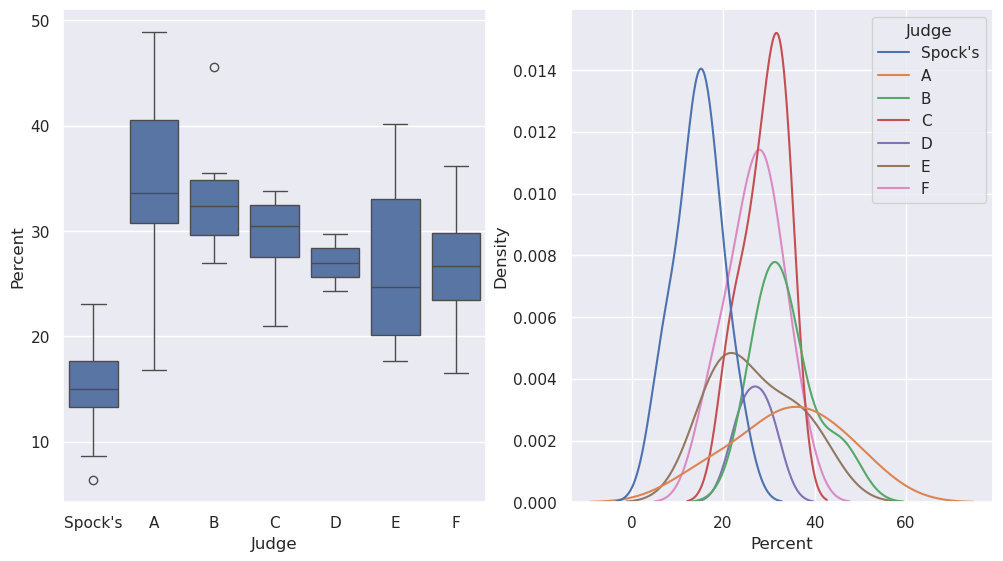

In [4]:
fig, axes = plt.subplots(ncols=2, figsize=[12, 6.4])
_ = sns.boxplot(data=df, x='Judge', y='Percent', ax=axes[0])
_ = sns.kdeplot(data=df, x='Percent', hue='Judge', ax=axes[1])

There is significant evidence against equal variance, and this should be a red flag.

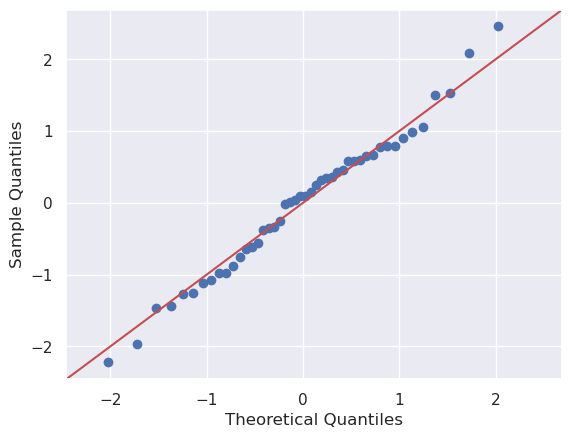

In [5]:
sm.qqplot(data=df['Percent'], line='45', fit=True)
plt.show()

There is weak evidence against normality.

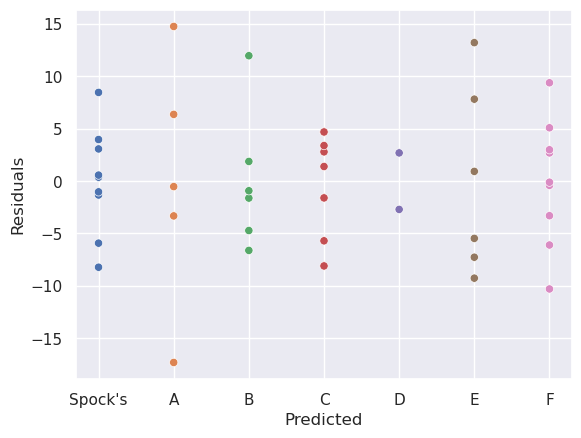

In [6]:
fig, ax = plt.subplots()
df['resid'] = model.resid
sns.scatterplot(data=df, x='Judge', y='resid', hue='Judge', ax=ax)
ax.set_ylabel('Residuals')
_ = ax.set_xlabel('Predicted')
ax.get_legend().set_visible(False)

The residuals seem to highlight the problem with Judge D's small sample size.

Despite the equal variance violation, the book plows forward.

## Is any judge different?

$
\begin{align}
H_0: \: &\mu_i = \mu_j \: \text{for} \: i, j \in \{A, B, C, D, E, F, Spock\} \: \text{(reduced model)} \\
H_a: \: &\text{at least one} \: \mu_i \ne \mu_j \: \text{for} \: i, j \in \{A, B, C, D, E, F, Spock\} \: \text{(full model)} \\
\end{align}
$

In [7]:
pd.options.display.float_format = "{:.4f}".format
adf = sm.stats.anova_lm(model)
print(adf)

              df    sum_sq  mean_sq      F  PR(>F)
Judge     6.0000 1927.0809 321.1801 6.7184  0.0001
Residual 39.0000 1864.4452  47.8063    NaN     NaN


There is strong evidence that at least one judge's percentages are different ($F_{6,39}$ = 6.7184, $p$-value = 0.0001).

We can manually run the test as well.

In [8]:
ssr1, sse1 = adf['sum_sq']
dof_ssr1, dof_sse1 = adf['df']
dof_sst1, sst1 = adf['df'].sum(), adf['sum_sq'].sum()

fstat = (ssr1 / dof_ssr1) / (sse1 / dof_sse1)
print(fstat, 1 - f.cdf(fstat, dof_ssr1, dof_sse1))

6.7183661238613634 6.09582276793752e-05


## Are judges A-F different?


<table>
    <tr>
        <th>Group</th><td>Spock</td><td>A</td><td>B</td><td>C</td><td>D</td><td>E</td><td>F</td>
    </tr>
    <tr>
      <th>Full Model</th><td>$\mu_1$</td><td>$\mu_2$</td><td>$\mu_3$</td><td>$\mu_4$</td><td>$\mu_5$</td><td>$\mu_6$</td><td>$\mu_7$</td></tr>
        <tr>
      <th>Reduced Model ($H_0$)</th><td>$\mu_1$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td></tr>
</table>

The necessary data values for this hypothesis test are not directly produced by **sm.stats.anova_lm** and **smf.ols**.  The sum of squares error (SSE) for the full model is provided above.  The total sum of squares (SST) for the reduced model can be obtained with a 2nd one-way analysis with just two groups, **Spock** and **Other**, but the SST that we are looking for is actually the SSE in the 2nd table.

In [9]:
df['Judge2'] = df['Judge']
df.loc[df['Judge'] != "Spock's", 'Judge2'] = 'Other'
model = smf.ols('Percent ~ C(Judge2, Treatment)', data=df).fit()
adf2 = sm.stats.anova_lm(model)
print(adf2)

                          df    sum_sq   mean_sq       F  PR(>F)
C(Judge2, Treatment)  1.0000 1600.6230 1600.6230 32.1454  0.0000
Residual             44.0000 2190.9031   49.7933     NaN     NaN


In [10]:
sst2 = adf2.loc['Residual', 'sum_sq']
dof_sst2 = adf2.loc['Residual', 'df']

The extra-sum-of-squares test can now be performed for the question at hand, are judges A-F different?

In [11]:
extra_ss = (sst2 - sse1)
extra_dof = (dof_sst2 - dof_sse1)
fstat =  (extra_ss / extra_dof) / (sse1 / dof_sse1)
print(fstat, extra_dof, dof_sse1, (1 - f.cdf(fstat, extra_dof, dof_sse1)))

1.3657529846824976 5.0 39.0 0.25817935736128095


There is only weak evidence that judges A-f differ from each other ($F_{5,39}$ = 1.37, $p$-value = 0.2582).

## Is Spock's judge different from the others?

<table>
    <tr>
        <th>Group</th><td>Spock</td><td>A</td><td>B</td><td>C</td><td>D</td><td>E</td><td>F</td>
    </tr>
    <tr>
      <th>Full Model</th><td>$\mu_1$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td><td>$\mu_0$</td></tr>
        <tr>
      <th>Reduced Model ($H_0$)</th><td>$\mu$</td><td>$\mu$</td><td>$\mu$</td><td>$\mu$</td><td>$\mu$</td><td>$\mu$</td><td>$\mu$</td></tr>
</table>

This is directly answered above, there is strong evidence that Spock's judge differs from the other judges ($F_{1,44}$ = 32.1454, $p$-value < 0.0001).

# Non-parametric ANOVA

## Is any judge different?

$
\begin{align}
H_0: \: &\mu_i = \mu_j \: \text{for} \: i, j \in \{A, B, C, D, E, F, Spock\} \: \text{(reduced model)} \\
H_a: \: &\text{at least one} \: \mu_i \ne \mu_j \: \text{for} \: i, j \in \{A, B, C, D, E, F, Spock\} \: \text{(full model)} \\
\end{align}
$

In [12]:
pg.kruskal(data=df, dv='Percent', between='Judge')

,Source,ddof1,H,p-unc
Kruskal,Judge,6,21.9647,0.0012


There is strong evidence that at least one judge has percentages that differ from the others ($H_6$ = 21.96, $p$-value = 0.0012).

# Are any of judges A-F different?

$
\begin{align}
H_0: \: &\mu_i = \mu_j \: \text{for} \: i, j \in \{A, B, C, D, E, F\} \: \text{(reduced model)} \\
H_a: \: &\text{at least one} \: \mu_i \ne \mu_j \: \text{for} \: i, j \in \{A, B, C, D, E, F\} \: \text{(full model)} \\
\end{align}
$

In [13]:
spock = "Spock's"
pg.kruskal(data=df.query('Judge != @spock'), dv='Percent', between='Judge')

,Source,ddof1,H,p-unc
Kruskal,Judge,5,5.5480,0.3527


There is weak evidence that any of judges A-F are different ($H_5$ = 5.548, $p$-value = 0.3527).

# Is Spock's Judge different from Judges A-F?

In [14]:
pg.kruskal(data=df, dv='Percent', between='Judge2')

,Source,ddof1,H,p-unc
Kruskal,Judge2,1,18.1881,0.0000


There is strong evidence that Spock's judge is different from Judge's A-F ($H_1$ = 18.1881, $p$-value < 0.0001).